
# 小地域の収入推定

```Data```フォルダには、小地域の収入データ(```income_district.csv```)と国勢調査の小地域集計データが格納されています。

国勢調査の小地域集計データ（人口構成、労働力構成、住宅形態など）から、その地域の収入を推定することが考えられます。推定のための機械学習・深層学習モデルを構築しなさい。


- データを観察・理解する上で、データの構造を説明しながら、適切なデータ整形を行いなさい
- データ構造や分析結果に対して、少なくとも二つの図で可視化を行いなさい
- モデルの精度を評価し、できるだけ精度が高いモデルを得るよう、適切な特徴量エンジニアリングやモデル選定の考えもまとめなさい


In [2]:
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
df = pd.read_csv('income_district.csv')


In [6]:
income_df = pd.read_csv('income_district.csv')
age_df = pd.read_csv('h27_age_df.csv')
gender_df = pd.read_csv('h27_gender_df2.csv')
print("CSVファイルの読み込みに成功しました。")


CSVファイルの読み込みに成功しました。


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

すべてのCSVファイルの読み込みに成功しました。


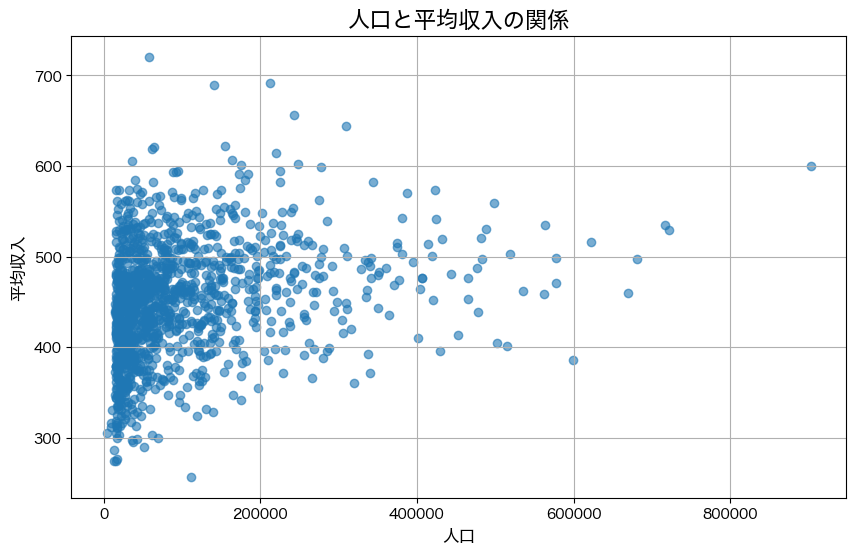

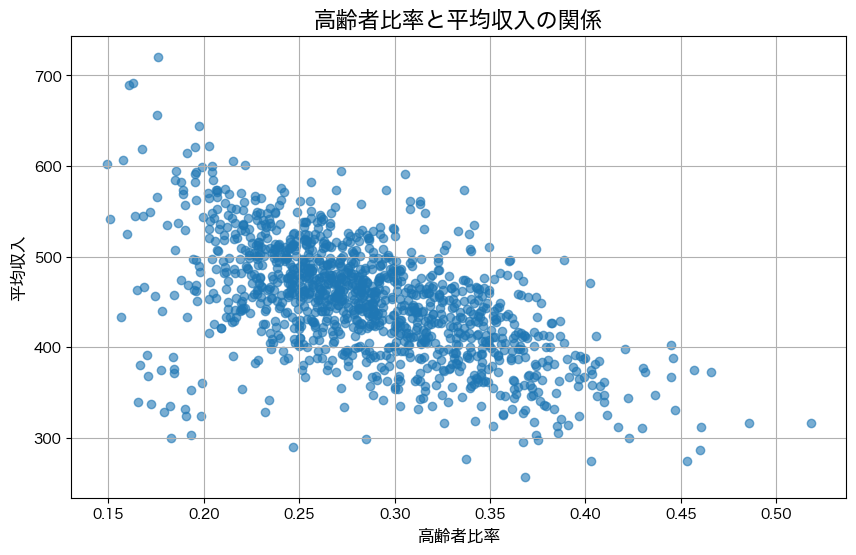


--- 最終的にモデル構築に使用するデータの構造 ---
最終データの行数: 1164

最終データの先頭5行:
   area_code    10-14    15-19    20-24    25-29    30-34    35-39    40-44  \
0      45201  19220.0  20777.0  17510.0  18611.0  22131.0  26144.0  29081.0   
1      45202   7897.0   7689.0   6393.0   7661.0   9132.0   9783.0  10200.0   
2      45203   5950.0   5980.0   4499.0   5139.0   6176.0   7096.0   7846.0   
3      45204   2187.0   2294.0   1807.0   1957.0   2548.0   2813.0   2904.0   
4      45205   2056.0   1962.0   1279.0   1788.0   2315.0   2515.0   2475.0   

     45-49    50-54  ...  population  male_population  female_population  \
0  25070.0  24686.0  ...    401138.0         188177.0           212961.0   
1   8775.0   9707.0  ...    165029.0          77521.0            87508.0   
2   6846.0   7538.0  ...    125159.0          58993.0            66166.0   
3   2634.0   3242.0  ...     54090.0          25374.0            28716.0   
4   2278.0   2722.0  ...     46221.0          21426.0            24795.0   

   family_

In [ ]:
font_candidates = ['Hiragino Sans', 'IPAexGothic', 'IPA P Gothic', 'Noto Sans CJK JP', 'Noto Sans JP', 'MS Gothic', 'Yu Gothic', 'sans-serif']
japanese_font = ''
for font in fm.fontManager.ttflist:
    if any(candidate in font.name for candidate in font_candidates):
        japanese_font = font.name
        break

if japanese_font:
    plt.rcParams['font.family'] = japanese_font
else:
    print("日本語フォントが見つかりませんでした。英語でラベルを生成します。")
    plt.rcParams['font.family'] = 'sans-serif'


try:
    income_df = pd.read_csv('income_district.csv')
    age_df = pd.read_csv('h27_age_df.csv')
    gender_df = pd.read_csv('h27_gender_df2.csv')
    print("すべてのCSVファイルの読み込みに成功しました。")
except FileNotFoundError as e:
    print(f"ファイルが見つかりませんでした: {e}")
    exit()

age_df_filtered = age_df[age_df['level_identifier'] == 1].copy()
gender_df_filtered = gender_df[gender_df['level_identifier'] == 1].copy()

age_numeric_cols = age_df_filtered.columns[7:]
age_df_filtered[age_numeric_cols] = age_df_filtered[age_numeric_cols].replace({'X': np.nan, '-': np.nan}).apply(pd.to_numeric, errors='coerce')

gender_numeric_cols = ['population', 'male_population', 'female_population', 'family_count']
gender_df_filtered[gender_numeric_cols] = gender_df_filtered[gender_numeric_cols].replace({'X': np.nan, '-': np.nan}).apply(pd.to_numeric, errors='coerce')


merged_census_df = pd.merge(age_df_filtered, gender_df_filtered, on='district_id', how='inner')
merged_census_df.rename(columns={'district_id': 'area_code'}, inplace=True)


final_df = pd.merge(merged_census_df, income_df, on='area_code', how='inner')


final_df['male_ratio'] = final_df['male_population'] / final_df['population']
final_df['female_ratio'] = final_df['female_population'] / final_df['population']
final_df['child_ratio'] = (final_df['0-4_male'] + final_df['5-9_male'] + final_df['0-4_female'] + final_df['5-9_female']) / final_df['population']
final_df['elderly_ratio'] = (final_df['65-69'] + final_df['70-74'] + final_df['75-79'] + final_df['80-84'] + final_df['85-89'] + final_df['90-94'] + final_df['95-99'] + final_df['100']) / final_df['population']
final_df['dependency_ratio'] = final_df['child_ratio'] + final_df['elderly_ratio']


plt.figure(figsize=(10, 6))
plt.scatter(final_df['population'], final_df['income_mean'], alpha=0.6)
plt.title('人口と平均収入の関係', fontsize=16)
plt.xlabel('人口', fontsize=12)
plt.ylabel('平均収入', fontsize=12)
plt.grid(True)
plt.savefig('population_vs_income.png')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(final_df['elderly_ratio'], final_df['income_mean'], alpha=0.6)
plt.title('高齢者比率と平均収入の関係', fontsize=16)
plt.xlabel('高齢者比率', fontsize=12)
plt.ylabel('平均収入', fontsize=12)
plt.grid(True)
plt.savefig('elderly_ratio_vs_income.png')
plt.show()


final_df.drop(columns=[col for col in final_df.columns if '_x' in col or '_y' in col], inplace=True)
final_df.dropna(inplace=True)

X = final_df.drop(['area_code', 'income_mean'], axis=1)
y = final_df['income_mean']


print("\n--- 最終的にモデル構築に使用するデータの構造 ---")
print(f"最終データの行数: {len(final_df)}")
print("\n最終データの先頭5行:")
print(final_df.head())
print("\n最終データの情報:")
final_df.info()


final_df.to_csv('final_model_data.csv', index=False)
print("\n整形および特徴量エンジニアリング後のデータを 'final_model_data.csv' として保存しました。")

すべてのCSVファイルの読み込みに成功しました。

--- 最終データフレームの構造 ---
最終的に結合されたデータの行数: 1238

最終データフレームの先頭5行:
   area_code  district2_id_age  level_identifier_age state_name_age  \
0      45201               NaN                     1            宮崎県   
1      45202               NaN                     1            宮崎県   
2      45203               NaN                     1            宮崎県   
3      45204               NaN                     1            宮崎県   
4      45205               NaN                     1            宮崎県   

  city_name_age district_name_age district2_name_age    10-14    15-19  \
0           宮崎市               NaN                NaN  19220.0  20777.0   
1           都城市               NaN                NaN   7897.0   7689.0   
2           延岡市               NaN                NaN   5950.0   5980.0   
3           日南市               NaN                NaN   2187.0   2294.0   
4           小林市               NaN                NaN   2056.0   1962.0   

     20-24  ...  level_identifier_gender  

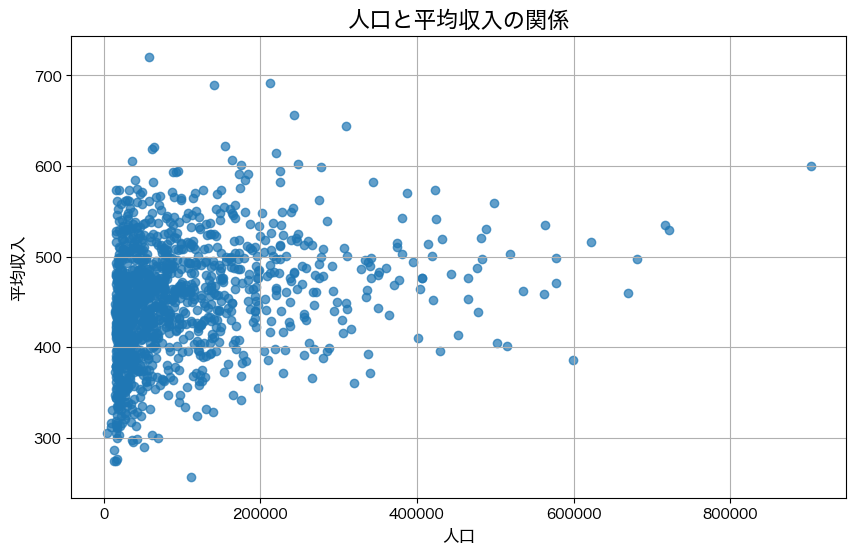

KeyError: 'elderly_dependency_ratio'

<Figure size 1000x600 with 0 Axes>

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Setting up a list of Japanese fonts
font_candidates = ['Hiragino Sans', 'IPAexGothic', 'IPA P Gothic', 'Noto Sans CJK JP', 'Noto Sans JP', 'MS Gothic', 'Yu Gothic', 'sans-serif']
japanese_font = ''
for font in fm.fontManager.ttflist:
    if any(candidate in font.name for candidate in font_candidates):
        japanese_font = font.name
        break

if japanese_font:
    plt.rcParams['font.family'] = japanese_font
else:
    print("日本語フォントが見つかりませんでした。英語でラベルを生成します。")
    plt.rcParams['font.family'] = 'sans-serif'

# 1. Load the datasets
try:
    income_df = pd.read_csv('income_district.csv')
    age_df = pd.read_csv('h27_age_df.csv')
    gender_df = pd.read_csv('h27_gender_df2.csv')
    print("すべてのCSVファイルの読み込みに成功しました。")
except FileNotFoundError as e:
    print(f"ファイルが見つかりませんでした: {e}")
    exit()

# 2. Filter data to a specific level (City level)
age_city_df = age_df[age_df['level_identifier'] == 1].copy()
gender_city_df = gender_df[gender_df['level_identifier'] == 1].copy()

# 3. Clean and convert numeric columns
# The population and age-related columns are read as 'object' due to non-numeric values like 'X' and '-'.
age_numeric_cols = age_city_df.columns[7:].tolist()
gender_numeric_cols = ['population', 'male_population', 'female_population', 'family_count']

age_city_df[age_numeric_cols] = age_city_df[age_numeric_cols].replace(['X', '-'], np.nan).apply(pd.to_numeric, errors='coerce')
gender_city_df[gender_numeric_cols] = gender_city_df[gender_numeric_cols].replace(['X', '-'], np.nan).apply(pd.to_numeric, errors='coerce')

# 4. Rename 'district_id' for merging
age_city_df.rename(columns={'district_id': 'area_code'}, inplace=True)
gender_city_df.rename(columns={'district_id': 'area_code'}, inplace=True)

# 5. Merge the dataframes on the common 'area_code'
merged_census_df = pd.merge(age_city_df, gender_city_df, on='area_code', how='inner', suffixes=('_age', '_gender'))
final_df = pd.merge(merged_census_df, income_df, on='area_code', how='inner')

# 6. Display the final merged dataframe info and head to confirm
print("\n--- 最終データフレームの構造 ---")
print(f"最終的に結合されたデータの行数: {len(final_df)}")
print("\n最終データフレームの先頭5行:")
print(final_df.head())
print("\n最終データフレームの情報:")
final_df.info()

# Save the merged data to a CSV for future use
final_df.to_csv('final_merged_data.csv', index=False)
print("\n整形後のデータを 'final_merged_data.csv' として保存しました。")

# 7. Visualization
# We can create new features and then visualize them.
# Example: create a feature for dependency ratio.


# Plot 1: Scatter plot of population vs. income
plt.figure(figsize=(10, 6))
plt.scatter(final_df['population'], final_df['income_mean'], alpha=0.7)
plt.title('人口と平均収入の関係', fontsize=16)
plt.xlabel('人口', fontsize=12)
plt.ylabel('平均収入', fontsize=12)
plt.grid(True)
plt.savefig('population_vs_income.png')
plt.show()

# Plot 2: Scatter plot of elderly dependency ratio vs. income
plt.figure(figsize=(10, 6))
plt.scatter(final_df['elderly_dependency_ratio'], final_df['income_mean'], alpha=0.7)
plt.title('高齢者従属人口比率と平均収入の関係', fontsize=16)
plt.xlabel('高齢者従属人口比率', fontsize=12)
plt.ylabel('平均収入', fontsize=12)
plt.grid(True)
plt.savefig('elderly_dependency_ratio_vs_income.png')
plt.show()